In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set initial seed for random sampling
rng = np.random.default_rng(5731)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Load in dataset and set up new columns
data = pd.read_csv('zaw_table_4.csv').sort_values(by=['sigma'])

# Divide by factor of 200 to scale velocity dispersion according to paper
data['sigma'] /= 200 
data['e_sigma'] /= 200

# Multiply by factor of 10^7 to scale black hole mass according to paper
data['MassBH'] *= 1E7 
data['E_MassBH'] *= 1E7
data['e_MassBH'] *= 1E7

# Set up intercept
data['Intercept'] = np.ones(data['Name'].count())
data['e_Intercept'] = np.ones(data['Name'].count())*1e-1

# Convert to log velocity dispersion and keep only the largest log error
data['log_sigma'] = np.log10(data['sigma'])
data['e_log_sigma_upper'] = np.log10(1 + data['e_sigma']/data['sigma'])
data['e_log_sigma_lower'] = -np.log10(1 - data['e_sigma']/data['sigma'])
data['e_log_sigma'] = data[['e_log_sigma_upper', 'e_log_sigma_lower']].max(axis=1)

# Compute square of log velocity dispersion and propagate (gaussian) error
data['log_sigma^2'] = np.log10(data['sigma'])**2
data['e_log_sigma^2'] = 2*np.abs(data['log_sigma'])*data['e_log_sigma']

# Convert to log black hole mass and keep only the largest log error
data['log_MassBH'] = np.log10(data['MassBH'])
data['e_log_MassBH_upper'] = np.log10(1 + data['E_MassBH']/data['MassBH'])
data['e_log_MassBH_lower'] = -np.log10(1 - data['e_MassBH']/data['MassBH'])
data['e_log_MassBH'] = data[['e_log_MassBH_upper', 'e_log_MassBH_lower']].max(axis=1)

# Set up response and error for linear model
X = np.array(data[['Intercept', 'log_sigma']])
X_err = np.array(data[['e_Intercept', 'e_log_sigma']])

# Set up response and error for quadratic model
X_q = np.array(data[['Intercept', 'log_sigma', 'log_sigma^2']])
X_q_err = np.array(data[['e_Intercept', 'e_log_sigma', 'e_log_sigma^2']])

# Set up covariate and error for both models
Y = np.array(data['log_MassBH'])
Y_err = np.array(data['e_log_MassBH'])

### Errorbar Plot of Dataset

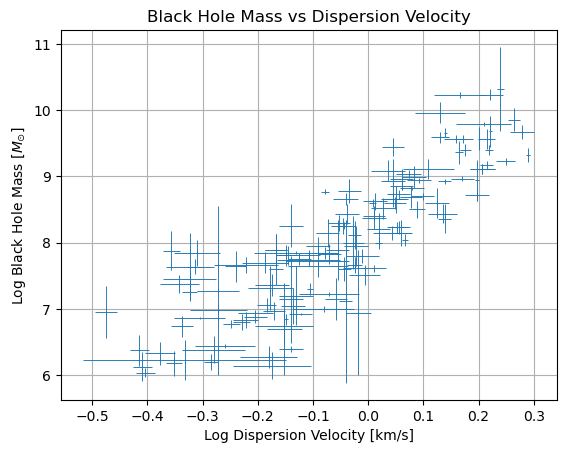

In [3]:
plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.grid()
plt.title('Black Hole Mass vs Dispersion Velocity')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.show()

# Linear Regression

In [4]:
def linear_regression(X, Y, m=0, c=1e2, samples=10000, draws=50):
    coords = {
        'galaxy': range(X.shape[0]),
        'parameters': ['Intercept', 'Sigma'],
    }

    with pm.Model(coords=coords):
        x = pm.Data('Sigma', X, dims=['galaxy', 'parameters'])

        # Model parameters
        betas = pm.Normal('beta', mu=m, sigma=c, dims='parameters')
        epsilon = pm.HalfNormal('epsilon', sigma=c)

        # Model
        mu = pm.Deterministic('mu', x @ betas)

        # Likelihood
        y = pm.Normal('MassBH', mu=mu, sigma=epsilon, observed=Y)

        # Sample posterior
        trace = pm.sample(samples)
        prior_pred = pm.sample_prior_predictive(draws=draws, random_seed=rng)
        post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)
        return trace, prior_pred, post_pred

In [5]:
# Apply the linear regression model and show table of results
l_trace, l_prior_pred, l_post_pred = linear_regression(X, Y)
pm.summary(l_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, epsilon]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.
Sampling: [MassBH, beta, epsilon]
Sampling: [MassBH]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Intercept],8.282,0.047,8.196,8.372,0.000,0.000,53979.0,32113.0,1.0
beta[Sigma],5.009,0.253,4.530,5.483,0.001,0.001,51277.0,33104.0,1.0
epsilon,0.531,0.033,0.471,0.594,0.000,0.000,49138.0,29844.0,1.0
mu[0],5.903,0.118,5.675,6.117,0.001,0.000,55007.0,31609.0,1.0
mu[1],6.205,0.104,6.006,6.397,0.000,0.000,55609.0,31427.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[135],9.481,0.086,9.324,9.647,0.000,0.000,48835.0,31616.0,1.0
mu[136],9.530,0.088,9.369,9.700,0.000,0.000,48838.0,31643.0,1.0
mu[137],9.602,0.091,9.432,9.775,0.000,0.000,48844.0,31722.0,1.0
mu[138],9.678,0.094,9.505,9.860,0.000,0.000,48849.0,31590.0,1.0


### Posterior Plot

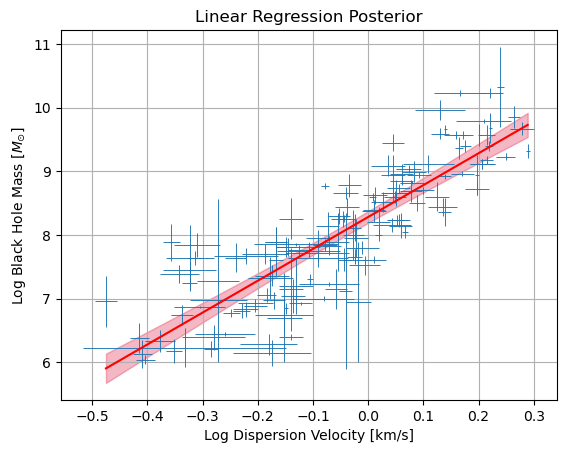

In [6]:
# Calculate quantiles for posterior black hole mass data
Y_mean = np.quantile(l_trace.posterior.mu.values, 0.50, axis=(0, 1))
Y_lower = np.quantile(l_trace.posterior.mu.values, 0.025, axis=(0, 1))
Y_upper = np.quantile(l_trace.posterior.mu.values, 0.975, axis=(0, 1))

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.plot(data['log_sigma'], Y_mean, color='red', label='Best-fit Line')
plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
plt.title('Linear Regression Posterior')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()

### Posterior Predictive Check

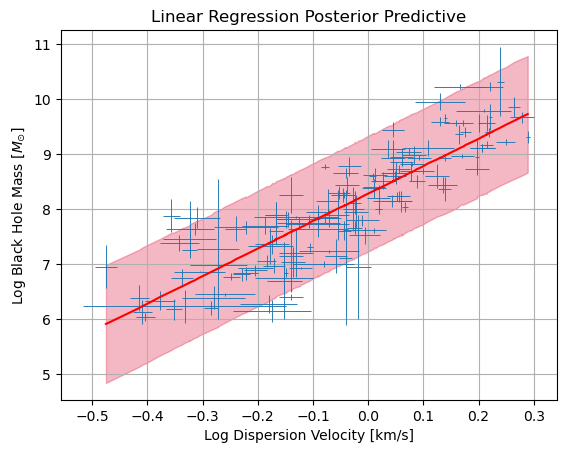

In [7]:
# Calculate quantiles for posterior predictive black hole mass data
Y_mean = np.quantile(l_post_pred.posterior_predictive.MassBH.values, 0.50, axis=(0, 1))
Y_lower = np.quantile(l_post_pred.posterior_predictive.MassBH.values, 0.025, axis=(0, 1))
Y_upper = np.quantile(l_post_pred.posterior_predictive.MassBH.values, 0.975, axis=(0, 1))

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.plot(data['log_sigma'], Y_mean, color='red', label='Best-fit Line')
plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
plt.title('Linear Regression Posterior Predictive')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()

### Prior Predictive Check

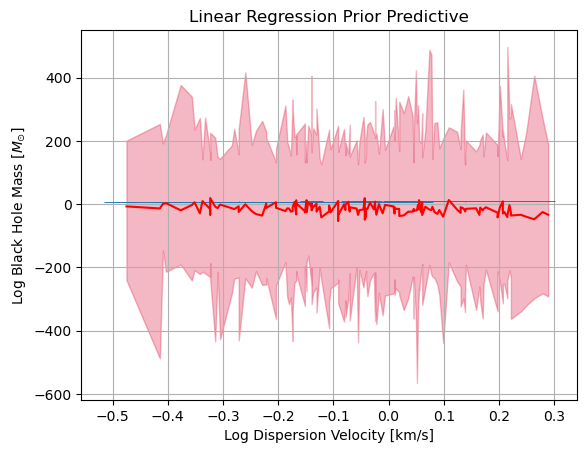

In [8]:
# Calculate quantiles for prior predictive black hole mass data
Y_mean = np.quantile(l_prior_pred.prior_predictive.MassBH.values, 0.50, axis=(0, 1))
Y_lower = np.quantile(l_prior_pred.prior_predictive.MassBH.values, 0.025, axis=(0, 1))
Y_upper = np.quantile(l_prior_pred.prior_predictive.MassBH.values, 0.975, axis=(0, 1))

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.plot(data['log_sigma'], Y_mean, color='red', label='Best-fit Line')
plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
plt.title('Linear Regression Prior Predictive')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()

# Quadratic Regression

In [9]:
def quadratic_regression(X, Y, m=0, c=1e2, samples=10000, draws=50):
    coords = {
        'galaxy': range(X.shape[0]),
        'parameters': ['Intercept', 'Sigma', 'Sigma^2'],
    }

    with pm.Model(coords=coords):
        x = pm.Data('Sigma', X, dims=['galaxy', 'parameters'])

        # Model parameters
        betas = pm.Normal('beta', mu=m, sigma=c, dims='parameters')
        epsilon = pm.HalfNormal('epsilon', sigma=c)

        # Model
        mu = pm.Deterministic('mu', x @ betas)

        # Likelihood
        y = pm.Normal('MassBH', mu=mu, sigma=epsilon, observed=Y)

        # Sample posterior
        trace = pm.sample(samples)
        prior_pred = pm.sample_prior_predictive(draws=draws, random_seed=rng)
        post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)
        return trace, prior_pred, post_pred

In [10]:
# Apply the quadratic regression model and show table of results
q_trace, q_prior_pred, q_post_pred = quadratic_regression(X_q, Y)
pm.summary(q_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, epsilon]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 23 seconds.
Sampling: [MassBH, beta, epsilon]
Sampling: [MassBH]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Intercept],8.165,0.056,8.060,8.270,0.000,0.000,28263.0,28644.0,1.0
beta[Sigma],5.559,0.294,4.997,6.107,0.002,0.001,30082.0,28747.0,1.0
beta[Sigma^2],4.264,1.230,1.919,6.536,0.008,0.005,25870.0,27105.0,1.0
epsilon,0.511,0.031,0.453,0.569,0.000,0.000,34054.0,28464.0,1.0
mu[0],6.487,0.202,6.104,6.860,0.001,0.001,37319.0,33227.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[135],9.740,0.112,9.529,9.952,0.001,0.000,31389.0,28601.0,1.0
mu[136],9.816,0.118,9.585,10.032,0.001,0.000,30836.0,28462.0,1.0
mu[137],9.927,0.129,9.676,10.163,0.001,0.001,30124.0,28465.0,1.0
mu[138],10.046,0.140,9.777,10.306,0.001,0.001,29565.0,28064.0,1.0


### Posterior Plot

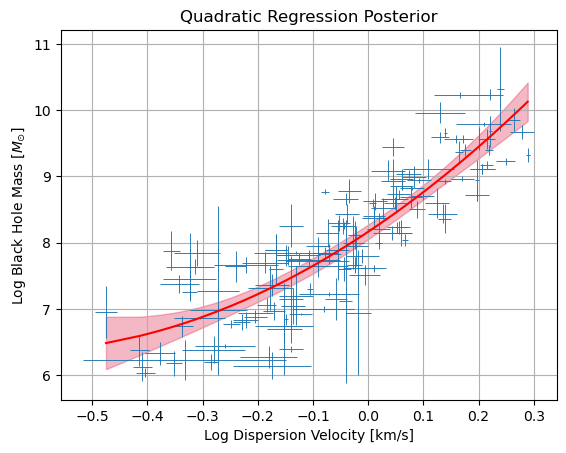

In [11]:
# Calculate quantiles for posterior black hole mass data
Y_mean = np.quantile(q_trace.posterior.mu.values, 0.50, axis=(0, 1))
Y_lower = np.quantile(q_trace.posterior.mu.values, 0.025, axis=(0, 1))
Y_upper = np.quantile(q_trace.posterior.mu.values, 0.975, axis=(0, 1))

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.plot(data['log_sigma'], Y_mean, color='red', label='Best-fit Line')
plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
plt.title('Quadratic Regression Posterior')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()

### Posterior Predictive Check

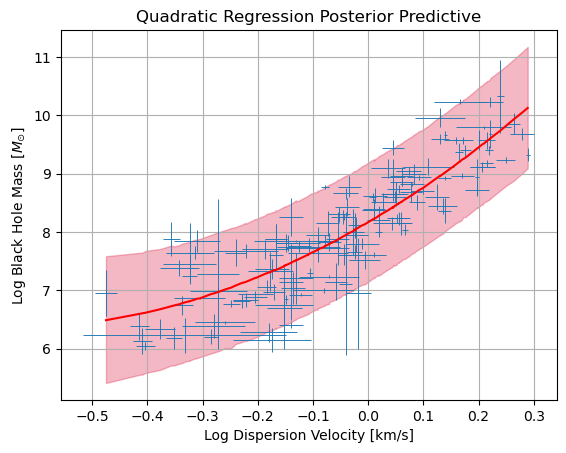

In [12]:
# Calculate quantiles for posterior predictive black hole mass data
Y_mean = np.quantile(q_post_pred.posterior_predictive.MassBH.values, 0.50, axis=(0, 1))
Y_lower = np.quantile(q_post_pred.posterior_predictive.MassBH.values, 0.025, axis=(0, 1))
Y_upper = np.quantile(q_post_pred.posterior_predictive.MassBH.values, 0.975, axis=(0, 1))

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.plot(data['log_sigma'], Y_mean, color='red', label='Best-fit Line')
plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
plt.title('Quadratic Regression Posterior Predictive')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()

### Prior Predictive Check

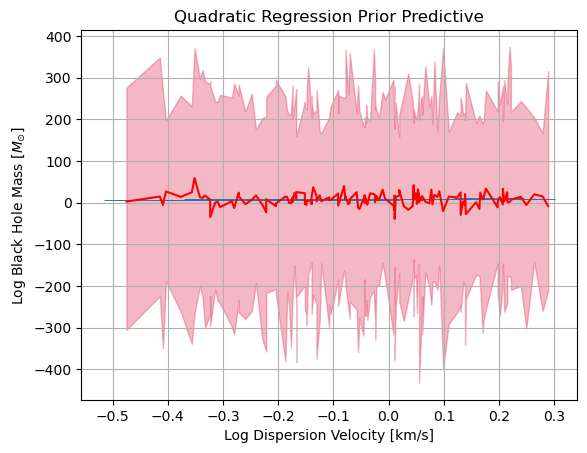

In [13]:
# Calculate quantiles for prior predictive black hole mass data
Y_mean = np.quantile(q_prior_pred.prior_predictive.MassBH.values, 0.50, axis=(0, 1))
Y_lower = np.quantile(q_prior_pred.prior_predictive.MassBH.values, 0.025, axis=(0, 1))
Y_upper = np.quantile(q_prior_pred.prior_predictive.MassBH.values, 0.975, axis=(0, 1))

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.plot(data['log_sigma'], Y_mean, color='red', label='Normal Best-fit Line')
plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
plt.title('Quadratic Regression Prior Predictive')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()

# Linear Regression with Measurement Error

In [14]:
def me_linear_regression(X, Y, X_std, Y_std, c=1e-3, d=1e-3, e=0.5, f=0.5, samples=10000, draws=50):
    coords = {
        'galaxy': range(X.shape[0]),
        'parameters': ['Intercept', 'Sigma'],
    }
    
    with pm.Model(coords=coords):
        tau = pm.Gamma('tau', alpha=e, beta=f)
        betas = pm.Normal('beta', mu=0, tau=d, dims='parameters')
        X_true = pm.Normal('X_true', mu=0, tau=c, dims=['galaxy', 'parameters'])
        X_obs = pm.Normal('X_obs', mu=X_true, sigma=X_std, observed=X)
        Y_true = pm.Normal('Y_true', mu=(X_obs @ betas), tau=tau)
        Y_obs = pm.Normal('Y_obs', mu=Y_true, sigma=Y_std, observed=Y)

        # Sample posterior
        trace = pm.sample(samples)
        prior_pred = pm.sample_prior_predictive(draws=draws, random_seed=rng)
        post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)
        return trace, prior_pred, post_pred

In [15]:
# Apply the linear regression model and show table of results
me_l_trace, me_l_prior_pred, me_l_post_pred = me_linear_regression(X, Y, X_err, Y_err)
pm.summary(me_l_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 73 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Intercept],8.292,0.045,8.208,8.377,0.000,0.000,75119.0,32779.0,1.0
beta[Sigma],5.080,0.249,4.606,5.545,0.001,0.001,80410.0,32078.0,1.0
"X_true[0, Intercept]",1.000,0.101,0.813,1.188,0.000,0.000,97376.0,25709.0,1.0
"X_true[0, Sigma]",-0.475,0.020,-0.512,-0.437,0.000,0.000,93001.0,26011.0,1.0
"X_true[1, Intercept]",1.001,0.100,0.817,1.193,0.000,0.000,93089.0,25699.0,1.0
...,...,...,...,...,...,...,...,...,...
Y_true[136],9.235,0.054,9.131,9.337,0.000,0.000,95891.0,26195.0,1.0
Y_true[137],9.830,0.166,9.520,10.144,0.001,0.000,79901.0,25881.0,1.0
Y_true[138],9.674,0.101,9.482,9.863,0.000,0.000,91703.0,25450.0,1.0
Y_true[139],9.344,0.106,9.148,9.547,0.000,0.000,91970.0,26828.0,1.0


### Posterior Predictive Check

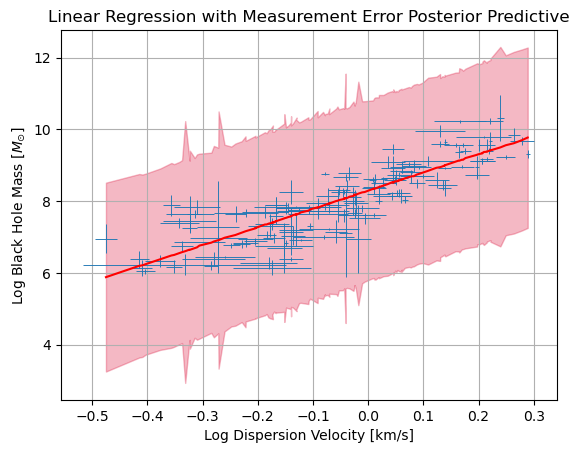

In [16]:
# Calculate quantiles for posterior predictive velocity dispersion data
X_mean = np.quantile(me_l_post_pred.posterior_predictive.X_obs.values, 0.50, axis=(0, 1))[:, 1]
X_lower = np.quantile(me_l_post_pred.posterior_predictive.X_obs.values, 0.025, axis=(0, 1))[:, 1]
X_upper = np.quantile(me_l_post_pred.posterior_predictive.X_obs.values, 0.975, axis=(0, 1))[:, 1]

# Calculate quantiles for posterior predictive black hole mass data
Y_mean = np.quantile(me_l_post_pred.posterior_predictive.Y_obs.values, 0.50, axis=(0, 1))
Y_lower = np.quantile(me_l_post_pred.posterior_predictive.Y_obs.values, 0.025, axis=(0, 1))
Y_upper = np.quantile(me_l_post_pred.posterior_predictive.Y_obs.values, 0.975, axis=(0, 1))

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.plot(X_mean, Y_mean, color='red', label='Best-fit Line')
plt.fill_between(X_mean, Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
# plt.fill_between(np.sort(X_lower), Y_lower[np.argsort(X_lower)], Y_upper[np.argsort(X_lower)], color='crimson', alpha=0.3, label="95% Credible Region")
# plt.fill_between(np.sort(X_upper), Y_lower[np.argsort(X_upper)], Y_upper[np.argsort(X_upper)], color='crimson', alpha=0.3, label="95% Credible Region")
# plt.fill_betweenx(np.sort(Y_mean), X_lower[np.argsort(Y_mean)], X_upper[np.argsort(Y_mean)], color='crimson', alpha=0.3, label="95% Credible Region")
plt.title('Linear Regression with Measurement Error Posterior Predictive')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()

# Quadratic Regression with Measurement Error

In [17]:
def me_quadratic_regression(X, Y, X_std, Y_std, c=1e-3, d=1e-3, e=0.5, f=0.5, samples=1000, draws=50):
    coords = {
        'galaxy': range(X.shape[0]),
        'parameters': ['Intercept', 'Sigma', 'Sigma^2'],
    }

    with pm.Model(coords=coords):
        tau = pm.Gamma('tau', alpha=e, beta=f)
        betas = pm.Normal('beta', mu=0, tau=d, dims='parameters')
        X_true = pm.Normal('X_true', mu=0, tau=c, dims=['galaxy', 'parameters'])
        X_obs = pm.Normal('X_obs', mu=X_true, sigma=X_std, observed=X)
        Y_true = pm.Normal('Y_true', mu=(X_obs @ betas), tau=tau)
        Y_obs = pm.Normal('Y_obs', mu=Y_true, sigma=Y_std, observed=Y)

        # Sample posterior
        trace = pm.sample(samples)
        prior_pred = pm.sample_prior_predictive(draws=draws, random_seed=rng)
        post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)
        return trace, prior_pred, post_pred

In [18]:
# Apply the quadratic regression model and show table of results
me_q_trace, me_q_prior_pred, me_q_post_pred = me_quadratic_regression(X_q, Y, X_q_err, Y_err)
pm.summary(me_q_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Intercept],8.197,0.056,8.088,8.296,0.001,0.000,6501.0,3420.0,1.0
beta[Sigma],5.502,0.295,4.968,6.084,0.004,0.003,6792.0,3422.0,1.0
beta[Sigma^2],3.431,1.250,1.071,5.653,0.016,0.012,5901.0,3633.0,1.0
"X_true[0, Intercept]",0.999,0.101,0.804,1.183,0.001,0.001,13029.0,2459.0,1.0
"X_true[0, Sigma]",-0.475,0.020,-0.510,-0.437,0.000,0.000,11677.0,2485.0,1.0
...,...,...,...,...,...,...,...,...,...
Y_true[136],9.237,0.053,9.142,9.339,0.000,0.000,11541.0,2985.0,1.0
Y_true[137],9.863,0.168,9.533,10.162,0.002,0.001,12283.0,2286.0,1.0
Y_true[138],9.687,0.102,9.490,9.867,0.001,0.001,11083.0,2915.0,1.0
Y_true[139],9.360,0.107,9.152,9.554,0.001,0.001,11783.0,2701.0,1.0


### Posterior Predictive Check

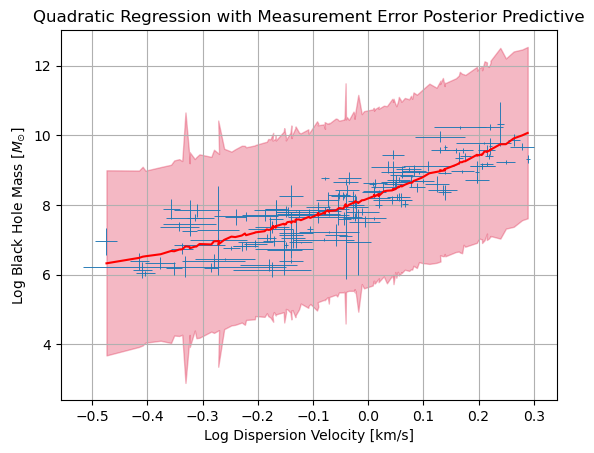

In [19]:
# Calculate quantiles for posterior predictive velocity dispersion data
X_mean = np.quantile(me_q_post_pred.posterior_predictive.X_obs.values, 0.50, axis=(0, 1))[:, 1]
X_lower = np.quantile(me_q_post_pred.posterior_predictive.X_obs.values, 0.025, axis=(0, 1))[:, 1]
X_upper = np.quantile(me_q_post_pred.posterior_predictive.X_obs.values, 0.975, axis=(0, 1))[:, 1]

# Calculate quantiles for posterior predictive black hole mass data
Y_mean = np.quantile(me_q_post_pred.posterior_predictive.Y_obs.values, 0.50, axis=(0, 1))
Y_lower = np.quantile(me_q_post_pred.posterior_predictive.Y_obs.values, 0.025, axis=(0, 1))
Y_upper = np.quantile(me_q_post_pred.posterior_predictive.Y_obs.values, 0.975, axis=(0, 1))

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.plot(X_mean, Y_mean, color='red', label='Best-fit Line')
plt.fill_between(X_mean, Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
# plt.fill_between(np.sort(X_lower), Y_lower[np.argsort(X_lower)], Y_upper[np.argsort(X_lower)], color='crimson', alpha=0.3, label="95% Credible Region")
# plt.fill_between(np.sort(X_upper), Y_lower[np.argsort(X_upper)], Y_upper[np.argsort(X_upper)], color='crimson', alpha=0.3, label="95% Credible Region")
# plt.fill_betweenx(np.sort(Y_mean), X_lower[np.argsort(Y_mean)], X_upper[np.argsort(Y_mean)], color='crimson', alpha=0.3, label="95% Credible Region")
plt.title('Quadratic Regression with Measurement Error Posterior Predictive')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()